# Wine Quality Prediction

## Preliminaries

In this little example we will look at several ways to predict the quality of wine based on several measurable quanities. But remember, waine tasting is largely a matter of personal taste.

Frist, let's invoke some of the imports we will need.

In [1]:
import tensorflow as tf
import numpy as np
import os
import urllib
import random
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import tarfile

Next we need to make sure we have the data sets we needed downloaded. First let's get our data sets.

In [2]:
white_wine_file = "winequality-white.csv"
if not os.path.exists(white_wine_file):
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", white_wine_file)

red_wine_file = "winequality-red.csv"
if not os.path.exists(red_wine_file):
    urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", red_wine_file)


Now we need to load and explore the data set. Load them into memory using the numpy tooling. The columns have the following meaings:
'fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality'. We will pretty much ignore these as we will be doing ML based only on non-expert traning straegies. We also separate out the labels from the features.

In [3]:

tags = np.array(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'])
ww = np.loadtxt(white_wine_file, skiprows=1, delimiter=';')
ww_labels = ww[:, 11]
ww_features = ww[:, range(11)]
rw = np.loadtxt(red_wine_file, skiprows=1, delimiter=';')
rw_labels = rw[:, 11]
rw_features = rw[:, range(11)]

w_hist, _ = np.histogram(ww_labels, [0,1,2,3,4,5,6,7,8,9,10,11])
r_hist, _ = np.histogram(rw_labels, [0,1,2,3,4,5,6,7,8,9,10,11])

print("White wine features:")
print("Histogram of labels (w) = ", w_hist)
for w in range(11):
    print("Feature = %20s  (min = %6.3f, ave = %6.3f, max = %6.3f)." % (tags[w], np.min(ww_features[:,w]), np.average(ww_features[:,w]), np.max(ww_features[:,w])))

print("\nRed wine features:")
print("Histogram of labels (r) = ", r_hist)
for w in range(11):
    print("Feature = %20s  (min = %6.3f, ave = %6.3f, max = %6.3f)." % (tags[w], np.min(rw_features[:,w]), np.average(rw_features[:,w]), np.max(rw_features[:,w])))


White wine features:
Histogram of labels (w) =  [   0    0    0   20  163 1457 2198  880  175    5    0]
Feature =        fixed acidity  (min =  3.800, ave =  6.855, max = 14.200).
Feature =     volatile acidity  (min =  0.080, ave =  0.278, max =  1.100).
Feature =          citric acid  (min =  0.000, ave =  0.334, max =  1.660).
Feature =       residual sugar  (min =  0.600, ave =  6.391, max = 65.800).
Feature =            chlorides  (min =  0.009, ave =  0.046, max =  0.346).
Feature =  free sulfur dioxide  (min =  2.000, ave = 35.308, max = 289.000).
Feature = total sulfur dioxide  (min =  9.000, ave = 138.361, max = 440.000).
Feature =              density  (min =  0.987, ave =  0.994, max =  1.039).
Feature =                   pH  (min =  2.720, ave =  3.188, max =  3.820).
Feature =            sulphates  (min =  0.220, ave =  0.490, max =  1.080).
Feature =              alcohol  (min =  8.000, ave = 10.514, max = 14.200).

Red wine features:
Histogram of labels (r) =  [  0   0 

## Data Segmentation

Next we need to divide our data into training, validation, and test data sets. Typically we target 80, 10, 10. Just in case the existing data has some existing assumptions about the order, we will take random samples or each data set. Notice that we explicitly set the random number generator seed. This way we get the same partitioning everytime we rerun the program. 

Given the histograms above, we will combine the classes for the first 5 classes into on and the last 3 in to 1.

From this point on we will focus on the white wine only. The red wine is left to the reader.

In [4]:
wn = len(ww_features)
random.seed(26)

# Select 3 or 5 classes. Notice that when changing the number of classes, you need to delete the temporary
# directories and their contents, e.g. bottleneck, retain_logs, SavedFeatures, wines, wines_te, wines_tr, wines_va.
n_classes = 3
if n_classes == 5:
    label_map = [0, 0, 0, 0, 0, 1, 2, 3, 4, 4, 4]
if n_classes == 3:
    label_map = [0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2]

ww_ind = random.sample(range(wn), wn)
ww_f_tr = np.array([ww_features[ww_ind[i]] for i in range(0, int(0.8*wn))])
ww_f_va = np.array([ww_features[ww_ind[i]] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_f_te = np.array([ww_features[ww_ind[i]] for i in range(int(0.9*wn)+1, wn-1)])
ww_l_tr = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(0, int(0.8*wn))])
ww_l_va = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.8*wn)+1, int(0.9*wn))])
ww_l_te = np.array([label_map[int(ww_labels[ww_ind[i]])] for i in range(int(0.9*wn)+1, wn-1)])

## K Nearest Neighbour Classification

Let's start with a simple K Nearest Neighbours (KNN) style machine learning. This is a straingt forwards process requiring only a single traing step. Notice that we only list the results for the validation set. This is because we will be tuning the KNN parameters and don't want to over fit against the testing data set. To train the KNN classifier you can change the numbr of neighboours and the weighting strategy ('uniform' or 'distance').

In [5]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(ww_f_tr, ww_l_tr)

# Look at 10 of our validation set:
for i in range(10):
    pred = knn.predict([ww_f_va[i]])[0]
    probs = knn.predict_proba([ww_f_va[i]])
    if n_classes == 5:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f %5.3f %5.3f" % 
            (pred, ww_l_va[i], probs[0][0], probs[0][1], probs[0][2], probs[0][3], probs[0][4]))
    if n_classes == 3:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f" % 
            (pred, ww_l_va[i], probs[0][0], probs[0][1], probs[0][2]))
    
# Run the complete validation data set.
score = knn.score(ww_f_va, ww_l_va)
print("\n Overall score = %5.2f%%" % (100.0*score))


Prediction = 1 Actual = 1 Probabilities = 0.199 0.801 0.000
Prediction = 2 Actual = 2 Probabilities = 0.276 0.291 0.433
Prediction = 0 Actual = 0 Probabilities = 0.639 0.361 0.000
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 2 Probabilities = 0.359 0.411 0.230
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 2 Actual = 2 Probabilities = 0.000 0.000 1.000
Prediction = 1 Actual = 1 Probabilities = 0.000 1.000 0.000
Prediction = 1 Actual = 1 Probabilities = 0.205 0.547 0.247
Prediction = 1 Actual = 1 Probabilities = 0.000 0.804 0.196

 Overall score = 63.60%


Lets have a closer look at how our system in performaing. We'll look at the false positives and false negatives for each class. False positive is where the class was incorrectly predicted; a false negative is where a wrong class was predicited. In our case we will have a false positive somewhere for every false negative, but any patterns in the distribution could be interesting.

In [6]:
fp = np.zeros(n_classes)
fn = np.zeros(n_classes)
n = len(ww_f_va)
tot = 0
print("N = ", n)
for i in range(n):
    pred = knn.predict([ww_f_va[i]])[0]
    if pred != ww_l_va[i]:
        tot = tot + 1
        fn[int(ww_l_va[i])] = fn[int(ww_l_va[i])] + 1
        fp[int(pred)] = fp[int(pred)] + 1

print("Total wrong = %3d. Eror rate = %8.4f%%" % (tot, 100.0*tot/n))
for i in range(n_classes):
    print("Class = %2d False positive = %3d (%5.1f%%) False negative = %3d (%5.1f%%)." % (i, fp[i], 100.0*fp[i]/n, fn[i
    ], 100.0*fn[i]/n))

N =  489


Total wrong = 178. Eror rate =  36.4008%
Class =  0 False positive =  48 (  9.8%) False negative =  57 ( 11.7%).
Class =  1 False positive =  85 ( 17.4%) False negative =  72 ( 14.7%).
Class =  2 False positive =  45 (  9.2%) False negative =  49 ( 10.0%).


The low false positives for the best and worst wines are encoraging. This means we are unlikely to be told a wine is good (or bad) incorrectly. However, we miss the oppertunity to sample about 4% of the best wines (false negatives), but these numbers too are relatively small.

Observing this ability to identify good, bad, and ok wines, the reader might wish to try further restricting the number of classes and see how well the classifier functions.

## Introduction to Imagification

The basic idea behine 'imigification' is that without needing to understand the detailed meaning of feature data we can still gain an insight into how well we might be able to classify this data. In the case of wine we were able to do pretty well with just using the KNN classifier, but in some cases there will be many more features or simply large volumes of data associated with each instance. In this case we want to develop a way to classify these without a detailed understanding of the specialist knowledge associated with the data.

We have also discovered that modern image perception networks are quite good with detail that sometimes humans miss. We would like to exploit this learning with a technique called transfer learning. So while the wine case may not seem to demand this approach, we'll have a go anyway to see how straight forward the process of imagification can be.

## Capturing the Data as Images

The first step in the process is to capture the data as images. Let's try a bar chart. [Note that we are normalizing all the features against the average across the whole data set so that all bars have about the same impact in the image.]Let's look at just one instance.

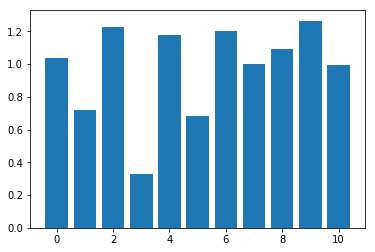

In [7]:
plt.close()
fig, bar = plt.subplots()
indx = range(11)
p = 50
features = [ww_f_tr[p][f]/np.average(ww_f_tr[:,f]) for f in range(11)]
bar.bar(indx, features)
plt.show()



Now we need to build the image data set to use in training the image recognizer. We will create three directories to stor the images, one each for training, validation, and testing. This step will take some time. Go have a coffee.

In [8]:
if not os.path.exists("wines_tr"):
    os.makedirs("wines_tr")

    f_inds = range(11)
    for p in range (len(ww_f_tr)):
        features = ww_f_tr[p]
        for f in f_inds:
            features[f] = features[f]/np.average(ww_f_tr[:,f])
            
        plt.close()
        _, bar = plt.subplots()
        bar.bar(f_inds, features)
        plt.savefig("wines_tr/WW%04d.jpeg"%(p))

if not os.path.exists("wines_va"):
    os.makedirs("wines_va")

    f_inds = range(11)
    for p in range (len(ww_f_va)):
        features = ww_f_va[p]
        for f in f_inds:
            features[f] = features[f]/np.average(ww_f_tr[:,f])
            
        plt.close()
        _, bar = plt.subplots()
        bar.bar(f_inds, features)
        plt.savefig("wines_va/WW%04d.jpeg"%(p))

if not os.path.exists("wines_te"):
    os.makedirs("wines_te")

    f_inds = range(11)
    for p in range (len(ww_f_te)):
        features = ww_f_te[p]
        for f in f_inds:
            features[f] = features[f]/np.average(ww_f_tr[:,f])
            
        plt.close()
        _, bar = plt.subplots()
        bar.bar(f_inds, features)
        plt.savefig("wines_te/WW%04d.jpeg"%(p))


## Transfer Learning

As simple approach to imagification and transfer learing is to remove the final layer of an existing image recognizer and replace it with a KNN classifier using the final pooling layer are the source for our features. This easily demonstrates the ability to adapt CNNs for use in transfer learning. The success of ths approach depends on how well our images capture the essential infomration.

First make sure the Inception and TensorFlow environment is set up.

In [9]:
if not os.path.exists("model"):
    os.makedirs("model")
    
if not os.path.exists("model/inception-2015-12-05.tgz"):
    filepath, _ = urllib.request.urlretrieve(
            "http://download.tensorflow.org/models/image/imagenet/inception-2015-12-05.tgz", "model/inception-2015-12-05.tgz")
    tarfile.open(filepath, 'r:gz').extractall("model")
 

Now we need to run all our images through the Inception CNN and then set up a KNN to train against the Known labels.

In [10]:
# Set up Inception CNN.
tf.reset_default_graph()
f = tf.gfile.FastGFile("model/classify_image_graph_def.pb", 'rb')
graph_def = tf.GraphDef()
graph_def.ParseFromString(f.read())
tf.import_graph_def(graph_def, name='')
sess = tf.Session()

if os.path.exists ("SavedFeatures/tr_f.npy"):

    tr_features = np.load("SavedFeatures/tr_f.npy")
    tr_labels = np.load("SavedFeatures/tr_l.npy")
    va_features = np.load("SavedFeatures/va_f.npy")
    va_labels = np.load("SavedFeatures/va_l.npy")
    te_features = np.load("SavedFeatures/te_f.npy")
    te_labels = np.load("SavedFeatures/te_l.npy")

else:

    os.makedirs("SavedFeatures")
    
    pool3 = sess.graph.get_tensor_by_name('pool_3:0')

    tr_features = np.empty((len(ww_f_tr), 2048), dtype='float32')
    tr_labels = np.empty(len(ww_l_tr), dtype='int')
    for i in range(len(ww_f_tr)):
        image_f = "wines_tr/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        tr_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        tr_labels[i] = ww_l_tr[i]
        if i % 100 == 0:
            print("Generating training feature set for image number = ", i)

    va_features = np.empty((len(ww_f_va), 2048), dtype='float32')
    va_labels = np.empty(len(ww_l_va), dtype='int')
    for i in range(len(ww_f_va)):
        image_f = "wines_va/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        va_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        va_labels[i] = ww_l_va[i]
        if i % 100 == 0:
            print("Generating validation feature set for image number = ", i)
            
    te_features = np.empty((len(ww_f_te), 2048), dtype='float32')
    te_labels = np.empty(len(ww_l_te), dtype='int')
    for i in range(len(ww_f_te)):
        image_f = "wines_te/WW%04d.jpeg" % (i)
        image = tf.gfile.FastGFile(image_f, 'rb').read()
        te_features[i] = sess.run(pool3, {'DecodeJpeg/contents:0': image})[0][0][0]
        te_labels[i] = ww_l_te[i]
        if i % 100 == 0:
            print("Generating ttest feature set for image number = ", i)

    np.save("SavedFeatures/tr_f.npy", tr_features)
    np.save("SavedFeatures/tr_l.npy", tr_labels)
    np.save("SavedFeatures/va_f.npy", va_features)
    np.save("SavedFeatures/va_l.npy", va_labels)
    np.save("SavedFeatures/te_f.npy", te_features)
    np.save("SavedFeatures/te_l.npy", te_labels)


Now train and validate our KNN based on the features extracted from the images.

In [11]:
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')
knn.fit(tr_features, tr_labels)

# Look at 10 of our validation set:
for i in range(10):
    pred = knn.predict([va_features[i]])[0]
    probs = knn.predict_proba([va_features[i]])
    if n_classes == 5:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f %5.3f %5.3f" % 
               (pred, va_labels[i], probs[0][0], probs[0][1], probs[0][2], probs[0][3], probs[0][4]))
    if n_classes == 3:
        print ("Prediction = %1d Actual = %1d Probabilities = %5.3f %5.3f %5.3f" % 
               (pred, va_labels[i], probs[0][0], probs[0][1], probs[0][2]))

# Run the complete validation data set.
score = knn.score(va_features, va_labels)
print("\n Overall score = %5.2f%%" % (100.0*score))


Prediction = 0 Actual = 1 Probabilities = 0.432 0.381 0.187
Prediction = 1 Actual = 2 Probabilities = 0.000 0.812 0.188
Prediction = 1 Actual = 0 Probabilities = 0.184 0.816 0.000
Prediction = 1 Actual = 1 Probabilities = 0.398 0.602 0.000
Prediction = 1 Actual = 2 Probabilities = 0.000 0.826 0.174
Prediction = 1 Actual = 1 Probabilities = 0.210 0.593 0.198
Prediction = 1 Actual = 2 Probabilities = 0.184 0.639 0.177
Prediction = 1 Actual = 1 Probabilities = 0.229 0.771 0.000
Prediction = 0 Actual = 1 Probabilities = 0.442 0.371 0.187
Prediction = 2 Actual = 1 Probabilities = 0.201 0.397 0.402

 Overall score = 39.47%


Prediction = 0 Actual = 1 Probabilities = 0.432 0.381 0.187
Prediction = 1 Actual = 2 Probabilities = 0.000 0.812 0.188
Prediction = 1 Actual = 0 Probabilities = 0.184 0.816 0.000
Prediction = 1 Actual = 1 Probabilities = 0.398 0.602 0.000
Prediction = 1 Actual = 2 Probabilities = 0.000 0.826 0.174
Prediction = 1 Actual = 1 Probabilities = 0.210 0.593 0.198
Prediction = 1 Actual = 2 Probabilities = 0.184 0.639 0.177
Prediction = 1 Actual = 1 Probabilities = 0.229 0.771 0.000
Prediction = 0 Actual = 1 Probabilities = 0.442 0.371 0.187


Prediction = 2 Actual = 1 Probabilities = 0.201 0.397 0.402



 Overall score = 39.47%


In [12]:
fp = np.zeros(11)
fn = np.zeros(11)
n = len(va_labels)
tot = 0
print("N = ", n)
for i in range(n):
    pred = knn.predict([va_features[i]])[0]
    if pred != va_labels[i]:
        tot = tot + 1
        fn[int(va_labels[i])] = fn[int(va_labels[i])] + 1
        fp[int(pred)] = fp[int(pred)] + 1

print("Total wrong = %3d. Eror rate = %8.4f%%" % (tot, 100.0*tot/n))
for i in range(n_classes):
    print("Class = %2d False positive = %3d (%5.1f%%) False negative = %3d (%5.1f%%)." % (i, fp[i], 100.0*fp[i]/n, fn[i
    ], 100.0*fn[i]/n))

        

N =  489


Total wrong = 296. Eror rate =  60.5317%
Class =  0 False positive = 118 ( 24.1%) False negative = 102 ( 20.9%).
Class =  1 False positive = 150 ( 30.7%) False negative =  96 ( 19.6%).
Class =  2 False positive =  28 (  5.7%) False negative =  98 ( 20.0%).


In [13]:

# Build the nested directory structure needed for the retraining approach.
if not os.path.exists("wines"):
    if n_classes == 5:
        os.makedirs("wines")
        os.makedirs("wines/undrinkable")
        os.makedirs("wines/poor")
        os.makedirs("wines/ok")
        os.makedirs("wines/good")
        os.makedirs("wines/excellent")
    if n_classes == 3:
        os.makedirs("wines")
        os.makedirs("wines/undrinkable")
        os.makedirs("wines/ok")
        os.makedirs("wines/excellent")
    
    f_inds = range(11)
    for p in range (len(ww_features)):
        features = ww_features[p]
        for f in f_inds:
            features[f] = features[f]/np.average(ww_features[:,f])
            
        plt.close()
        _, bar = plt.subplots()
        bar.bar(f_inds, features)
        lab = label_map[int(ww_labels[p])]
        if lab == 0:
            plt.savefig("wines/undrinkable/WW%04d.jpeg"%(p))
        if lab == 1:
            if n_classes == 5:
                plt.savefig("wines/poor/WW%04d.jpeg"%(p))
            if n_classes == 3:
                plt.savefig("wines/ok/WW%04d.jpeg"%(p))
        if lab == 2:
            if n_classes == 5:
                plt.savefig("wines/ok/WW%04d.jpeg"%(p))
            if n_classes == 3:
                plt.savefig("wines/excellent/WW%04d.jpeg"%(p))
        if lab == 3:
            plt.savefig("wines/good/WW%04d.jpeg"%(p))
        if lab == 4:
            plt.savefig("wines/excellent/WW%04d.jpeg"%(p))

The retrain.py application is part or the TensorFlow distribution and is discussed in detail in this tutorial: https://www.tensorflow.org/tutorials/image_retraining. This application has many options hat are worth exploring in the source code, but for now we will run it with just the defaults, which we have editied to meet our wines example.

In [14]:
%run "retrain.py"

Not extracting or downloading files, model already present in disk
Model path:  ./model\classify_image_graph_def.pb


INFO:tensorflow:Looking for images in 'excellent'


INFO:tensorflow:Looking for images in 'ok'


INFO:tensorflow:Looking for images in 'undrinkable'


INFO:tensorflow:500 bottleneck files created.


INFO:tensorflow:1000 bottleneck files created.


INFO:tensorflow:1500 bottleneck files created.


INFO:tensorflow:2000 bottleneck files created.


INFO:tensorflow:2500 bottleneck files created.


INFO:tensorflow:3000 bottleneck files created.


INFO:tensorflow:3500 bottleneck files created.


INFO:tensorflow:4000 bottleneck files created.


INFO:tensorflow:4500 bottleneck files created.


INFO:tensorflow:5000 bottleneck files created.


INFO:tensorflow:5500 bottleneck files created.


INFO:tensorflow:6000 bottleneck files created.


INFO:tensorflow:6500 bottleneck files created.


INFO:tensorflow:7000 bottleneck files created.


INFO:tensorflow:7500 bottleneck files created.


INFO:tensorflow:8000 bottleneck files created.


INFO:tensorflow:8500 bottleneck files created.


INFO:tensorflow:9000 bottleneck files created.


INFO:tensorflow:9500 bottleneck files created.


INFO:tensorflow:2018-02-10 18:40:41.450969: Step 0: Train accuracy = 38.0%


INFO:tensorflow:2018-02-10 18:40:41.452975: Step 0: Cross entropy = 1.089443


INFO:tensorflow:2018-02-10 18:40:41.642478: Step 0: Validation accuracy = 39.0% (N=100)

INFO:tensorflow:2018-02-10 18:41:14.706454: Step 200: Train accuracy = 47.0%


INFO:tensorflow:2018-02-10 18:41:14.708461: Step 200: Cross entropy = 1.044380


INFO:tensorflow:2018-02-10 18:41:14.891947: Step 200: Validation accuracy = 51.0% (N=100)


INFO:tensorflow:2018-02-10 18:41:47.483696: Step 400: Train accuracy = 46.0%


INFO:tensorflow:2018-02-10 18:41:47.485722: Step 400: Cross entropy = 1.017137


INFO:tensorflow:2018-02-10 18:41:47.673187: Step 400: Validation accuracy = 46.0% (N=100)


INFO:tensorflow:2018-02-10 18:42:20.657930: Step 600: Train accuracy = 39.0%


INFO:tensorflow:2018-02-10 18:42:20.659905: Step 600: Cross entropy = 1.035388


INFO:tensorflow:2018-02-10 18:42:20.841386: Step 600: Validation accuracy = 50.0% (N=100)


INFO:tensorflow:2018-02-10 18:42:53.648767: Step 800: Train accuracy = 52.0%


INFO:tensorflow:2018-02-10 18:42:53.650772: Step 800: Cross entropy = 0.959099


INFO:tensorflow:2018-02-10 18:42:53.833295: Step 800: Validation accuracy = 46.0% (N=100)


INFO:tensorflow:2018-02-10 18:43:26.933471: Step 1000: Train accuracy = 47.0%


INFO:tensorflow:2018-02-10 18:43:26.935464: Step 1000: Cross entropy = 1.012219


INFO:tensorflow:2018-02-10 18:43:27.133005: Step 1000: Validation accuracy = 46.0% (N=100)


INFO:tensorflow:2018-02-10 18:44:00.728746: Step 1200: Train accuracy = 56.0%


INFO:tensorflow:2018-02-10 18:44:00.729750: Step 1200: Cross entropy = 0.934570


INFO:tensorflow:2018-02-10 18:44:00.909256: Step 1200: Validation accuracy = 53.0% (N=100)


INFO:tensorflow:2018-02-10 18:44:33.816945: Step 1400: Train accuracy = 65.0%


INFO:tensorflow:2018-02-10 18:44:33.817949: Step 1400: Cross entropy = 0.918402


INFO:tensorflow:2018-02-10 18:44:34.011498: Step 1400: Validation accuracy = 55.0% (N=100)


INFO:tensorflow:2018-02-10 18:45:07.339087: Step 1600: Train accuracy = 62.0%


INFO:tensorflow:2018-02-10 18:45:07.340121: Step 1600: Cross entropy = 0.901706


INFO:tensorflow:2018-02-10 18:45:07.533604: Step 1600: Validation accuracy = 50.0% (N=100)

INFO:tensorflow:2018-02-10 18:45:40.369922: Step 1800: Train accuracy = 63.0%


INFO:tensorflow:2018-02-10 18:45:40.371927: Step 1800: Cross entropy = 0.981387


INFO:tensorflow:2018-02-10 18:45:40.559426: Step 1800: Validation accuracy = 47.0% (N=100)


INFO:tensorflow:2018-02-10 18:46:14.413550: Step 2000: Train accuracy = 44.0%


INFO:tensorflow:2018-02-10 18:46:14.414535: Step 2000: Cross entropy = 0.984128


INFO:tensorflow:2018-02-10 18:46:14.607047: Step 2000: Validation accuracy = 44.0% (N=100)


INFO:tensorflow:2018-02-10 18:46:47.464437: Step 2200: Train accuracy = 59.0%


INFO:tensorflow:2018-02-10 18:46:47.465423: Step 2200: Cross entropy = 0.886935


INFO:tensorflow:2018-02-10 18:46:47.652920: Step 2200: Validation accuracy = 50.0% (N=100)


INFO:tensorflow:2018-02-10 18:47:21.386534: Step 2400: Train accuracy = 56.0%


INFO:tensorflow:2018-02-10 18:47:21.388511: Step 2400: Cross entropy = 0.927718


INFO:tensorflow:2018-02-10 18:47:21.593052: Step 2400: Validation accuracy = 42.0% (N=100)


INFO:tensorflow:2018-02-10 18:47:54.586788: Step 2600: Train accuracy = 56.0%


INFO:tensorflow:2018-02-10 18:47:54.587794: Step 2600: Cross entropy = 0.946547


INFO:tensorflow:2018-02-10 18:47:54.770278: Step 2600: Validation accuracy = 54.0% (N=100)


INFO:tensorflow:2018-02-10 18:48:27.919697: Step 2800: Train accuracy = 61.0%


INFO:tensorflow:2018-02-10 18:48:27.920730: Step 2800: Cross entropy = 0.906913


INFO:tensorflow:2018-02-10 18:48:28.103183: Step 2800: Validation accuracy = 50.0% (N=100)


INFO:tensorflow:2018-02-10 18:49:01.111193: Step 3000: Train accuracy = 58.0%


INFO:tensorflow:2018-02-10 18:49:01.113233: Step 3000: Cross entropy = 0.918178


INFO:tensorflow:2018-02-10 18:49:01.292677: Step 3000: Validation accuracy = 47.0% (N=100)


INFO:tensorflow:2018-02-10 18:49:34.171104: Step 3200: Train accuracy = 58.0%


INFO:tensorflow:2018-02-10 18:49:34.172108: Step 3200: Cross entropy = 0.888952


INFO:tensorflow:2018-02-10 18:49:34.359615: Step 3200: Validation accuracy = 48.0% (N=100)


INFO:tensorflow:2018-02-10 18:50:10.641360: Step 3400: Train accuracy = 61.0%


INFO:tensorflow:2018-02-10 18:50:10.642365: Step 3400: Cross entropy = 0.911813


INFO:tensorflow:2018-02-10 18:50:10.820869: Step 3400: Validation accuracy = 50.0% (N=100)


INFO:tensorflow:2018-02-10 18:50:42.770798: Step 3600: Train accuracy = 54.0%


INFO:tensorflow:2018-02-10 18:50:42.772803: Step 3600: Cross entropy = 0.923449


INFO:tensorflow:2018-02-10 18:50:42.943257: Step 3600: Validation accuracy = 49.0% (N=100)


INFO:tensorflow:2018-02-10 18:51:15.128900: Step 3800: Train accuracy = 53.0%


INFO:tensorflow:2018-02-10 18:51:15.129935: Step 3800: Cross entropy = 0.903613


INFO:tensorflow:2018-02-10 18:51:15.298388: Step 3800: Validation accuracy = 54.0% (N=100)


INFO:tensorflow:2018-02-10 18:51:46.881336: Step 3999: Train accuracy = 56.0%


INFO:tensorflow:2018-02-10 18:51:46.882339: Step 3999: Cross entropy = 0.913086


INFO:tensorflow:2018-02-10 18:51:47.054826: Step 3999: Validation accuracy = 55.0% (N=100)


INFO:tensorflow:Final test accuracy = 50.5% (N=1038)


INFO:tensorflow:Froze 2 variables.


Converted 2 variables to const ops.


The End